In [2]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    return np.array(data, dtype=object)  # Ensure consistent dtype



In [4]:
train = get_data("chest_xrays/chest_xray/chest_xray/train")
test = get_data("chest_xrays/chest_xray/chest_xray/test")
val = get_data("chest_xrays/chest_xray/chest_xray/val")

In [5]:
pneumonia = os.listdir("chest_xrays/chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xrays/chest_xray/train/PNEUMONIA"

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

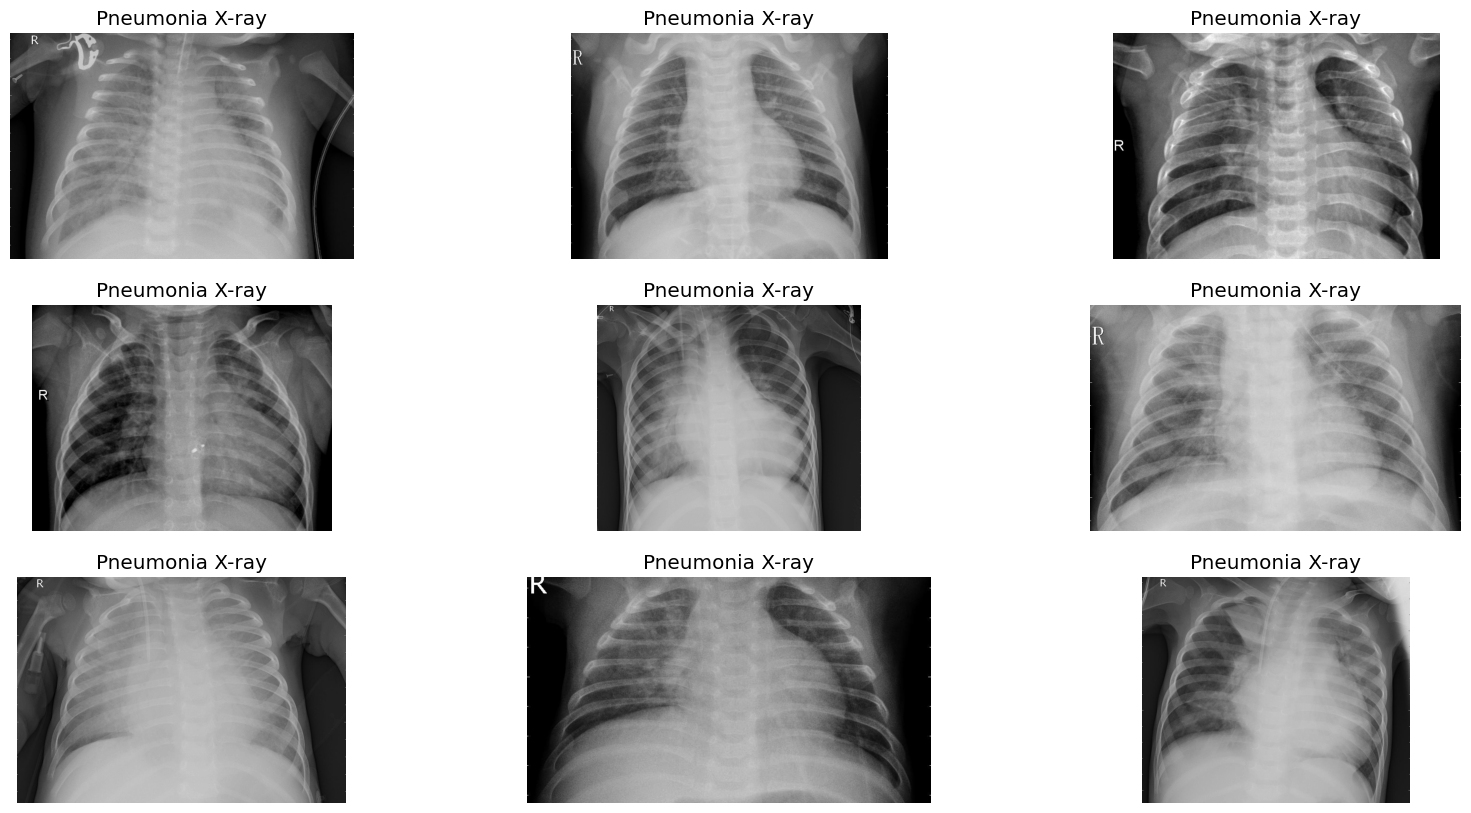

In [6]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout

In [7]:
normal = os.listdir("chest_xrays/chest_xray/train/NORMAL")
normal_dir = "chest_xrays/chest_xray/train/NORMAL"

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

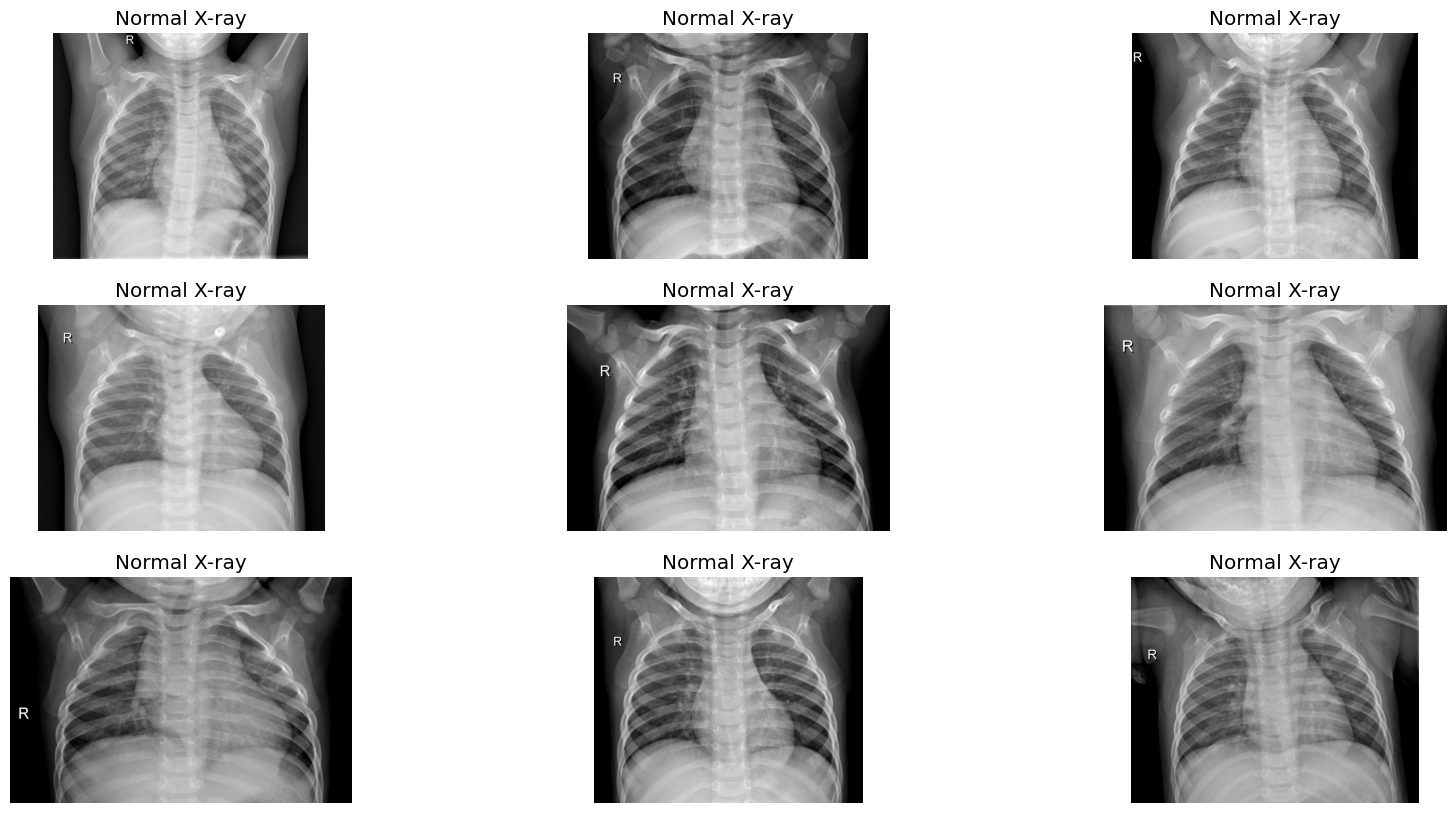

In [8]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout

C:\Users\izama\AppData\Local\Temp\ipykernel_15616\1323143147.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=listx, palette="Set2")


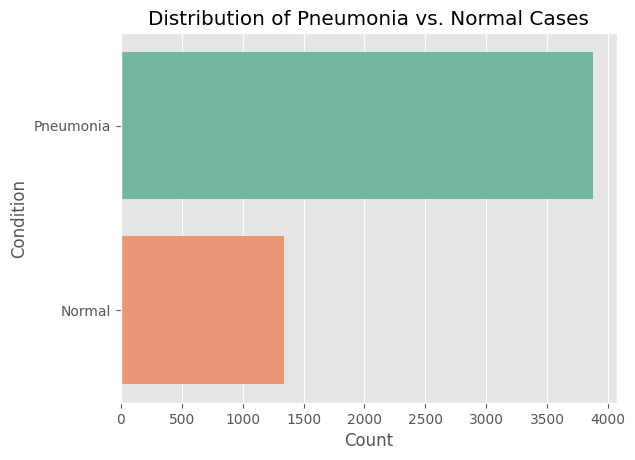

In [9]:
import seaborn as sns

listx = []
for i in train:
    if i[1] == 0:
        listx.append("Pneumonia")
    else:
        listx.append("Normal")

sns.countplot(y=listx, palette="Set2")  
plt.ylabel("Condition")
plt.xlabel("Count")
plt.title("Distribution of Pneumonia vs. Normal Cases")
plt.show()


### Data Argumentations & Resizing

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [11]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                   horizontal_flip=0.4,
                   vertical_flip=0.4,
                   rotation_range=40,
                   shear_range=0.2,
                   width_shift_range=0.4,
                   height_shift_range=0.4,
                   fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory("chest_xrays/chest_xray/train",
                                  batch_size = 32,
                                  target_size=(128,128),
                                  class_mode = 'categorical',
                                  shuffle=True,
                                  seed = 42,
                                  color_mode = 'rgb')

valid_generator = valid_datagen.flow_from_directory("chest_xrays/chest_xray/val",
                                  batch_size = 32,
                                  target_size=(128,128),
                                  class_mode = 'categorical',
                                  shuffle=True,
                                  seed = 42,
                                  color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
class_labels = train_generator.class_indices
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
class_name = {value:key for (key, value) in class_labels.items()}
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

### VGG19 CNN Architecture

In [15]:
base_model = VGG19(input_shape=(128,128,3),
                    include_top = False,
                    weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation= 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation= 'relu')(dropout)
output = Dense(2, activation= 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
filepath = "model.weights.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=True, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov= True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


c:\Users\izama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [17]:
history_01 = model_01.fit(train_generator,
             steps_per_epoch=50,
             epochs=20,
             callbacks=[es, cp, lrr],
             validation_data=valid_generator)

c:\Users\izama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.5991 - loss: 0.6685 - val_accuracy: 0.5000 - val_loss: 0.7820 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.7142 - loss: 0.5811 - val_accuracy: 0.5000 - val_loss: 0.7792 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7314 - loss: 0.5660 - val_accuracy: 0.5000 - val_loss: 0.7151 - learning_rate: 1.0000e-04
Epoch 4/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.7134 - loss: 0.5520

c:\Users\izama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - accuracy: 0.7334 - loss: 0.5384 - val_accuracy: 0.5000 - val_loss: 0.7264 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7467 - loss: 0.5263 - val_accuracy: 0.5000 - val_loss: 0.7174 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.7587 - loss: 0.5224 - val_accuracy: 0.5000 - val_loss: 0.6987 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7419 - loss: 0.5216 - val_accuracy: 0.5000 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 722ms/step - accuracy: 0.7566 - loss: 0.4899 - val_accuracy: 0.5000 - val_loss: 0.6849 - learning_rate: 1.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.7346 - loss: 0.5162 - val_accuracy: 0.5000 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.7520 - loss

In [18]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath="model_weights/vgg19_model_01.h5", overwrite=True)

In [19]:
test_generator = test_datagen.flow_from_directory("chest_xrays/chest_xray/test",
                                  batch_size = 32,
                                  target_size=(128,128),
                                  class_mode = 'categorical',
                                  shuffle=True,
                                  seed = 42,
                                  color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [20]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step - accuracy: 0.6250 - loss: 0.5801
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7068 - loss: 0.5485


In [21]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuracy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuracy: {vgg_test_eval_01[1]}")

Validation Loss: 0.5800594091415405
Validation Accuracy: 0.625
Test Loss: 0.5384747385978699
Test Accuracy: 0.7211538553237915


### Fine-tuning

In [22]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

for layer in base_model.layers:
    layer.trainable = False

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:
        set_trainable = True
    
    if set_trainable:
        layer.trainable = True
        print(f"Setting {layer.name} as trainable")
    else:
        print(f"Setting {layer.name} as non-trainable")

print(model_02.summary())

Setting input_layer_1 as non-trainable
Setting block1_conv1 as non-trainable
Setting block1_conv2 as non-trainable
Setting block1_pool as non-trainable
Setting block2_conv1 as non-trainable
Setting block2_conv2 as non-trainable
Setting block2_pool as non-trainable
Setting block3_conv1 as non-trainable
Setting block3_conv2 as non-trainable
Setting block3_conv3 as non-trainable
Setting block3_conv4 as non-trainable
Setting block3_pool as non-trainable
Setting block4_conv1 as non-trainable
Setting block4_conv2 as non-trainable
Setting block4_conv3 as non-trainable
Setting block4_conv4 as non-trainable
Setting block4_pool as non-trainable
Setting block5_conv1 as non-trainable
Setting block5_conv2 as non-trainable
Setting block5_conv3 as trainable
Setting block5_conv4 as trainable
Setting block5_pool as trainable


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 47,784,834 (182.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [23]:
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [26]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

c:\Users\izama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [27]:
history_02 = model_02.fit(train_generator, 
            steps_per_epoch=10,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

c:\Users\izama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_27']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7985 - loss: 0.4352 - val_accuracy: 0.6250 - val_loss: 0.5838 - learning_rate: 1.0000e-04


In [28]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [29]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step - accuracy: 0.6250 - loss: 0.5838
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6939 - loss: 0.5542
Validation Loss: 0.5838305950164795
Validation Accuarcy: 0.625
Test Loss: 0.5382886528968811
Test Accuarcy: 0.7163461446762085


### Unfreezing and fine tuning the entire network

In [30]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

c:\Users\izama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [33]:
history_03 = model_02.fit(train_generator, 
            steps_per_epoch=100,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

100/100 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.7895 - loss: 0.4378 - val_accuracy: 0.7500 - val_loss: 0.5540 - learning_rate: 1.0000e-04


In [34]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)